Tools

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [37]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=10000)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query arxiv papers")
print(arxiv.name) 

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [32]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=1000)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()

In [7]:
tavily.invoke("Provide me the recent AI news")

[{'title': 'AI News | Latest AI News, Analysis & Events',
  'url': 'https://www.artificialintelligence-news.com/',
  'content': 'March 4, 2025\nAutoscience Carl: The first AI scientist writing peer-reviewed papers\nApplications\nMarch 3, 2025\nDeep Learning\nAlibaba Qwen QwQ-32B: Scaled reinforcement learning showcase\nArtificial Intelligence\nMarch 6, 2025\nDeepSeek-R1 reasoning models rival OpenAI in performance\nArtificial Intelligence\nJanuary 20, 2025\nNew AI training techniques aim to overcome current challenges\nDeep & Reinforcement Learning\nNovember 28, 2024 [...] Artificial Intelligence\nMarch 14, 2025\nOpenAI and Google call for US government action to secure AI lead\n\nArtificial Intelligence\nMarch 14, 2025\nCBRE: Leveraging Artificial Intelligence for business growth\n\nAGI\nMarch 14, 2025\nManus AI agent: breakthrough in China’s agentic AI\n\nApplications\nMarch 13, 2025\nServiceNow deploys AI agents to boost enterprise workflows [...] AI News\nMarch 20, 2025\nUK ministe

Combining all the tools to integrate with our LLM

In [8]:
tools = [arxiv,wiki,tavily]


Initializing our LLM

In [10]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="qwen-qwq-32b")

In [11]:
llm.invoke("what is AI")

AIMessage(content='\n<think>\nOkay, the user asked "what is AI." Let me start by defining AI in simple terms. I should mention that AI stands for Artificial Intelligence. Then, I need to explain what that means. Maybe I can say it\'s the field of computer science focused on creating machines that can perform tasks requiring human-like intelligence. But I should be careful not to make it too technical right away.\n\nI should break it down into some key points. Perhaps start with a basic definition, then explain the goals of AI. Wait, the user might want examples of AI applications. Including examples like voice assistants, recommendation systems, and autonomous cars could help them understand better.\n\nOh, also, maybe differentiate between narrow AI and general AI. That\'s an important distinction. Narrow AI is what we have today, like Siri or Google Assistant, designed for specific tasks. General AI is hypothetical, where machines can handle any intellectual task a human can. That\'s 

In [12]:
llm_with_tools=llm.bind_tools(tools=tools)

Executing the call

In [13]:
llm_with_tools.invoke("what is the recent news on AI")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0732', 'function': {'arguments': '{"query": "recent news on AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 263, 'prompt_tokens': 355, 'total_tokens': 618, 'completion_time': 0.636698697, 'prompt_time': 0.031403426, 'queue_time': 0.262816592, 'total_time': 0.668102123}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_07cd5d759a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-876935d9-18e1-4677-a87d-12666c32effc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'recent news on AI'}, 'id': 'call_0732', 'type': 'tool_call'}], usage_metadata={'input_tokens': 355, 'output_tokens': 263, 'total_tokens': 618})

Workflow

In [15]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage # Human message or AI message
from typing import Annotated # Labelling
from langgraph.graph.message import add_messages # Reducers in langgraph

In [16]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [17]:
from IPython.display import Image,display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


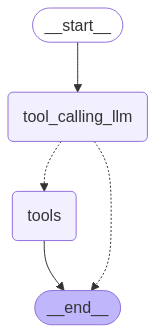

In [19]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools",END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [23]:
messages = graph.invoke({"messages":"1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_kcmw)
 Call ID: call_kcmw
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [33]:
messages = graph.invoke({"messages":"Who are you"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Who are you
================================== Ai Message ==================================

I am Qwen, a large language model developed by Alibaba Cloud. I'm designed to assist with a wide range of tasks, including answering questions, writing stories, composing emails, creating scripts, performing logical reasoning, and more. I can help you with information, solve problems, or engage in conversations. How can I assist you today?


In [27]:
messages = graph.invoke({"messages":"Recent news on AI and recent computing research paper"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Recent news on AI and recent computing research paper
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_vpzz)
 Call ID: call_vpzz
  Args:
    query: latest news on artificial intelligence advancements 2024
  arxiv (call_xzs3)
 Call ID: call_xzs3
  Args:
    query: recent computing research papers in AI and machine learning
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "2024: A year of extraordinary progress and advancement in AI", "url": "https://blog.google/technology/ai/2024-ai-extraordinary-progress-advancement/", "content": "This article summarizes Google's AI advancements in 2024, highlighting their commitment to responsible development.\nGoogle released Gemini 2.0, a powerful AI model designed for the \"agentic era,\" and integrated it into var

In [38]:
messages = graph.invoke({"messages":"Give me a Research paper on Big Data"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me a Research paper on Big Data
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_v97d)
 Call ID: call_v97d
  Args:
    query: Big Data
================================= Tool Message =================================
Name: arxiv

Published: 2020-12-15
Title: Big Data
Authors: Andreas L Opdahl, Vimala Nunavath
Summary: The Internet of Things, crowdsourcing, social media, public authorities, and
other sources generate bigger and bigger data sets. Big and open data offers
many benefits for emergency management, but also pose new challenges. This
chapter will review the sources of big data and their characteristics. We then
discuss potential benefits of big data for emergency management along with the
technological and socie
